# Market Regime Modeling - v1.0

https://lucid.app/lucidchart/1d1da6ad-2f5b-404e-a2e0-5fc09d555908/edit?view_items=sDP_6P2O9gUE&invitationId=inv_f6dfc2ff-a89c-4265-bff5-bedbb0340d49

In [2]:
# Libraries
import os
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# 1.Data Preparation

## Variables

In [2]:
# variables

base_index_name = "XAU Curncy" # Gold
# Base_index = "EUCRBRDT Index" # Crude oil

li_rolling_window = [
    10, # 2W
    21, # 1M
    42, # 2M
    65, # 3M
    ]
li_calculation_type = [
    "MA",
    "STD",
    "DIFF",
    ]

start_date = None
end_date = None

## Data loading and preprocessing

In [3]:
# Load dataset
dir = os.getcwd()
raw_data = pd.read_csv(os.path.join(dir,"INPUT/index_data.csv"))

# Convert date to datetime format from 8/2/23 to 2023-08-02
raw_data['Date'] = pd.to_datetime(raw_data['Date'], format='%d/%m/%y')
raw_data.set_index('Date', inplace=True)

# Data preprocessing - remove error/outliers
raw_data.dropna(axis='columns', inplace=True)

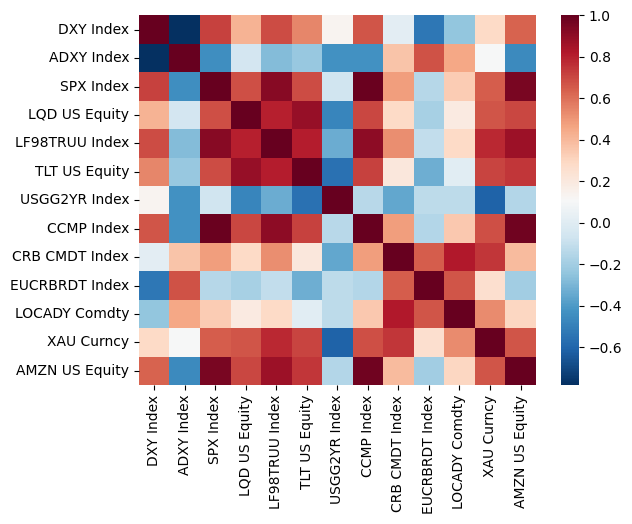

In [4]:
#sns.heatmap(raw_data.corr(),annot=False)
# change color map, cmap = reversed blue red
sns.heatmap(raw_data.corr(),annot=False,cmap='RdBu_r')
plt.show()

In [5]:
ref_data = pd.read_csv(os.path.join(dir,'INPUT/index_set.csv'))
df_index_set = ref_data[ref_data['group']==1][['set','index']]

In [7]:
raw_data.tail()

,DXY Index,ADXY Index,SPX Index,LQD US Equity,LF98TRUU Index,TLT US Equity,USGG2YR Index,CCMP Index,CRB CMDT Index,EUCRBRDT Index,LOCADY Comdty,XAU Curncy,AMZN US Equity
Date,,,,,,,,,,,,,
2023-02-08,103.409,102.46,4117.86,109.44,2276.17,105.56,4.4208,11910.52,553.96,84.56,9006.0,1875.49,100.05
2023-02-09,103.221,102.48,4081.50,108.52,2271.06,104.56,4.4820,11789.58,554.56,83.53,8953.5,1861.78,98.24
2023-02-10,103.630,102.17,4090.46,107.76,2253.47,103.39,4.5170,11718.12,553.72,85.87,8905.0,1865.57,97.61
2023-02-13,103.345,102.02,4137.29,108.16,2255.03,104.26,4.5175,11891.79,553.72,85.22,8912.0,1853.49,99.54
2023-02-14,103.221,102.07,4137.29,108.16,2255.03,104.26,4.5090,11891.79,553.72,85.12,8912.0,1856.01,99.54


In [6]:
df_index_set

,set,index
0,US_equity,SPX Index
1,Asian_currency,ADXY Index
2,US_bond_gov,TLT US Equity
3,US_bond_hg,LQD US Equity
4,Copper,LOCADY Comdty
5,US_rates,USGG2YR Index
6,US_equity_AMZN,AMZN US Equity
7,Crude oil,EUCRBRDT Index


## Feature engineering

In [ ]:
# raw_data: raw data, with index = Date

def preprocessing_scaler(raw_data, base_index):
    scaled_data = raw_data.div(raw_data.iloc[0], axis=1) # Divide by the first row to normalize the starting point to 1
    scaled_data = scaled_data.div(scaled_data.loc[:, base_index], axis=0) # Divide by Base price to neutralize the effect of inflation
    
    return scaled_data

def select_period(raw_data, start_date, end_date):

    #sort by date
    raw_data = raw_data.sort_index()

    if start_date == None:
        start_date = raw_data.index[0]
    if end_date == None:
        end_date = raw_data.index[-1]
   
    return raw_data.loc[start_date:end_date]

def group_data(raw_data,df_index_set):

    # select columns from raw data where column name is in index set['index']
    df_selected = raw_data[df_index_set['index']]

    # caculate the mean value of columns if columns are in the same set
    li_set = df_index_set['set'].unique()
    for set in li_set:
        df_selected[set] = df_selected[df_index_set[df_index_set['set'] == set]['index']].mean(axis=1)
    
    df_grouped = df_selected[li_set]

    return df_grouped

In [ ]:
def round_to_n_levels(values,n): # round values into n levels from 0 to 1

    values = (values-values.min())/(values.max()- values.min()) # normalize
    values = (values * n).round(0) / n # round to n levels
    return values

def construct_market_data(df_raw, li_rolling_window, li_calculation_type,rounded = True, round_level = 8):
    df_derived = pd.DataFrame()  # Create an empty DataFrame to store derived values

    for col in df_raw.columns:
        for rolling_window in li_rolling_window:
            col_data = df_raw[col]  # Extract the column data to improve readability

            if "MA" in li_calculation_type:
                ma_col_name = f'{col}_MA{rolling_window}'
                ma_values = col_data - col_data.rolling(window=rolling_window).mean()
                df_derived[ma_col_name] = (ma_values > 0).astype(int)  # Convert boolean to 0 or 1

            if "STD" in li_calculation_type:
                std_col_name = f'{col}_STD{rolling_window}'
                std_values = col_data.rolling(window=rolling_window).std() / col_data.rolling(window=rolling_window).mean()
                if rounded:
                    df_derived[std_col_name] = round_to_n_levels(values = std_values,n =round_level)
                

            if "DIFF" in li_calculation_type:
                diff_col_name = f'{col}_DIFF{rolling_window}'
                diff_values = col_data.diff(rolling_window)
                df_derived[diff_col_name] = (diff_values > 0).astype(int)  # Convert boolean to 0 or 1

    # Drop rows with missing values
    df_derived.dropna(axis=0, how='any', inplace=True)

    return df_derived


In [ ]:
#ignore warining
import warnings
warnings.filterwarnings('ignore')

df_scaled = preprocessing_scaler(raw_data, base_index)
df_period = select_period(df_scaled,start_date,end_date)
df_grouped = group_data(df_period,df_index_set)
df_derived = construct_market_data(df_grouped,li_rolling_window,li_calculation_type)

In [9]:
# variables
base_index_name = "XAU Curncy" # Gold
# Base_index = "EUCRBRDT Index" # Crude oil

li_rolling_window = [
    10, # 2W
    21, # 1M
    42, # 2M
    65, # 3M
    ]
li_calculation_type = [
    "MA",
    "STD",
    "DIFF",
    ]

start_date = None
end_date = None      

In [15]:
from datapreprocessing import DataPreprocessing


In [16]:

data_pre = DataPreprocessing(data = raw_data, 
                                base_index = base_index_name,
                                rolling_windows = li_rolling_window,
                                calculation_types = li_calculation_type,
                                start_date = start_date,
                                end_date = end_date,
                                grouped = True,
                                index_set = df_index_set,
                                rounded = True,
                                round_level = 8)

market_data = data_pre.construct_market_data()

AttributeError: 'DataPreprocessing' object has no attribute 'grouped'

In [ ]:
df_derived.tail(5)

In [ ]:
# data download
df_derived.to_csv(os.path.join(dir,'INPUT/market_data.csv'))

# 2. Data Analyisis

## Load processed data

In [3]:
# load data
dir = os.getcwd()
df_derived = pd.read_csv(os.path.join(dir,'INPUT/market_data.csv'), index_col=0)

In [4]:
market_data_PCA = df_derived.copy()
#select columns that do NOT start with 'US_equity_AMZN'
market_data = df_derived.loc[:,~df_derived.columns.str.startswith('US_equity_AMZN')]

## PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

market_data_transformed = StandardScaler().fit_transform(market_data_PCA)
pca = PCA()
principalComponents = pca.fit_transform(market_data_transformed)

principalDf = pd.DataFrame(data = principalComponents, columns=market_data_PCA.columns)
Ranking_PC0 = abs(principalDf.iloc[0,:])
Ranking_PC0.sort_values(ascending=False, inplace=True)

Ranking_PC1 = abs(principalDf.iloc[1,:])
Ranking_PC1.sort_values(ascending=False, inplace=True)

print('PC0 ranking')
print(Ranking_PC0[:10])
print()


print('PC1 ranking')
print(Ranking_PC1[:10])
print()
pca.explained_variance_ratio_.round(2)

# 3. Model

In [5]:
from model import HighDimensionalClustering
umap_kmeans = HighDimensionalClustering(reducer_name = 'UMAP', dimension= 2, Nneighbor=30, clustering_model_name = 'kMeans', Ncluster = 9)
umap_kmeans.clustering(market_data)

In [7]:
# add labels to the data
clusterable_embedding = umap_kmeans.low_dimension_embedding
labels = umap_kmeans.labels
df_labeled = market_data.copy()
df_labeled['label'] = labels

In [ ]:
# rename the labels by statistics of each cluster

def rename_labels(df_labeled, relabel_col):

    # rename lablels: rank of mean of US_equity_MA65 in each kmeans cluster(label) 
    df_summary = df_labeled.groupby("label")[relabel_col].describe()
    #df_summary['relabel'] = df_summary['mean'].rank(ascending= False).astype(int)
    df_summary['relabel'] = df_summary['mean'].rank().astype(int)

    # add column 'relabel' to df_labeled, keep the index of df_labeled
    df_relabeled = df_labeled.join(df_summary['relabel'], on = 'label')

    return df_relabeled

In [ ]:
df_relabeled = rename_labels(df_labeled, "US_equity_MA65")
df_relabeled

In [ ]:
# Calculate summary statistics for "US_equity_MA65" grouped by "ranking"
df_relabeled.groupby("relabel")["US_equity_MA65"].describe()

# Visualization

In [6]:
from visualizer import KMeansVisualizer
visualizer = KMeansVisualizer(clusterable_embedding, labels = np.array(df_relabeled['relabel']))
visualizer.plot_2d()

NameError: name 'clusterable_embedding' is not defined

In [ ]:
# plot the time series of "relabel" of df_labled
plt.plot(df_labeled[['relabel']].tail(500).reset_index(drop=True))

# Prediction and Evaluation - Naive Bayes

class sklearn.naive_bayes.CategoricalNB(*, alpha=1.0, force_alpha='warn', fit_prior=True, class_prior=None, min_categories=None)[source]¶

In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

nb_model = CategoricalNB()

In [ ]:
def build_dataset(relabels, window_period):

    Transition_table = pd.DataFrame(relabels, columns=['T']) # create a column T as Today's label
    Transition_table['Last_median_03'] = Transition_table['T'].shift(1).rolling(window=3).median() # compute the median of the previous 3 days
    Transition_table['Last_median_10'] = Transition_table['T'].shift(1).rolling(window=10).median() # compute the median of the previous 10 days
    Transition_table['Last_median_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).median() # compute the median of the previous window period
    # Transition_table['Last_mean_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).mean().round(0) # compute the mean of the previous window period
    Transition_table['Last_max_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).max() # compute the max of the previous window period
    Transition_table['Last_min_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).min() # compute the min of the previous window period
    dataset = Transition_table.iloc[window_period+1:,:] # remove NA rows

    return dataset


def naive_bayes(dataset, nb_model, if_eval):
    
    X = dataset.drop(['T'], axis=1)
    y = dataset['T']

    Last_X = X.iloc[-1] # get today's value

    if if_eval:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

        nb_model.fit(X_train, y_train)
        y_pred = nb_model.predict(X_test)
        # predit the last day #predict_proba return: array-like of shape (n_samples, n_classes)
        last_pred  = nb_model.predict_proba([Last_X]).round(2)[0] # make prediction
        accuracy = accuracy_score(y_test, y_pred)
    
    else:
        nb_model.fit(X, y)
        y_pred = nb_model.predict(X)
        last_pred  = nb_model.predict_proba([Last_X]).round(2)[0] # make prediction
        accuracy = None

    return last_pred, y_pred, accuracy

In [ ]:
relabels = list(df_relabeled["relabel"])
dataset = build_dataset(relabels, 20)
X = dataset.drop(['T'], axis=1)
y = dataset['T']
Last_X = X.iloc[-1] # get today's value
nb_model.fit(X, y)
y_pred = nb_model.predict(X)
last_pred  = nb_model.predict_proba([Last_X]).round(2)[0] # make prediction

In [ ]:
test = np.array([0])
test = np.add(last_pred, last_pred)

In [ ]:
(test/2).round(3)

In [ ]:
def display(df_labeled, relabel_col, monitor_period):

    df_relabeled = rename_labels(df_labeled, relabel_col)
    #mapping of labels and relabels
    mapping = dict(zip(df_relabeled["label"], df_relabeled["relabel"]))


    fig = px.area(
        df_relabeled[-monitor_period:],
        x=df_relabeled[-monitor_period:].index,
        y=df_relabeled[-monitor_period:]["relabel"],
        labels=dict(x="Date", y="Cycle Stage"),
        title=relabel_col,
        height=350, width=500,
        )
    
    fig.show()

    relabels = list(df_relabeled["relabel"])

    # Bayes model probability
    window_list = [i for i in range(20, 500) if i % 10 == 0]
    res = np.array([0])

    for window_period in window_list:

        dataset = build_dataset(relabels, window_period)
        res_i = naive_bayes(dataset, nb_model, if_eval = False)[0] # the list of probability for each culster
        res = np.add(res_i, res)
    
    n = len(window_list)
    res = (res/n).round(3)  # avarage probability for each culster
    res = pd.DataFrame(res)

    fig = px.bar(
        res,
        height=300, width=500,
        text_auto=True,
        )
    
    fig.show()

    # statistics of each cluster
    summary_table = df_relabeled.groupby("relabel")[relabel_col].describe()
    print(summary_table.round(2)) # mean column is the chance of market rally

    # summary
    summary_table['Chance'] = res
    summary_table['Equity_rally_odds'] = summary_table['mean'] * summary_table['Chance']
    summary_table['Equity_rally_STD'] = summary_table['std'] * summary_table['Chance']
    Mean = summary_table.Equity_rally_odds.sum().round(3)
    Std = summary_table.Equity_rally_STD.sum().round(3)
    
    print()
    print(mapping)

    print('Chance of rally in '+ relabel_col)
    print(Mean)
    print('Standard deviation')
    print(Std)

In [ ]:
# select all column names ending with _MA21
col_list = df_labeled.columns[df_labeled.columns.str.endswith('_MA21')]
monitor_period = 600
col_list

# Display

In [ ]:
import warnings
warnings.filterwarnings("ignore")

for relabel_col in col_list:

    display(df_labeled,relabel_col, monitor_period)